=== ЛАБОРАТОРНАЯ РАБОТА №1 - KNN ===
Загрузка и предобработка данных...
[5.0%] Загрузка данных (время: 0.0с)
✓ Недвижимость: данные успешно загружены
Определена кодировка файла авиакомпаний: Windows-1252
✓ Авиакомпании: данные успешно загружены с автоматически определенной кодировкой
Недвижимость: (4801, 17)
Колонки недвижимости: ['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE']
Авиакомпании: (50000, 14)
Колонки авиакомпаний: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
[15.0%] Анализ структуры данных (время: 17.9с)

=== АНАЛИЗ ДАННЫХ НЕДВИЖИМОСТИ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480

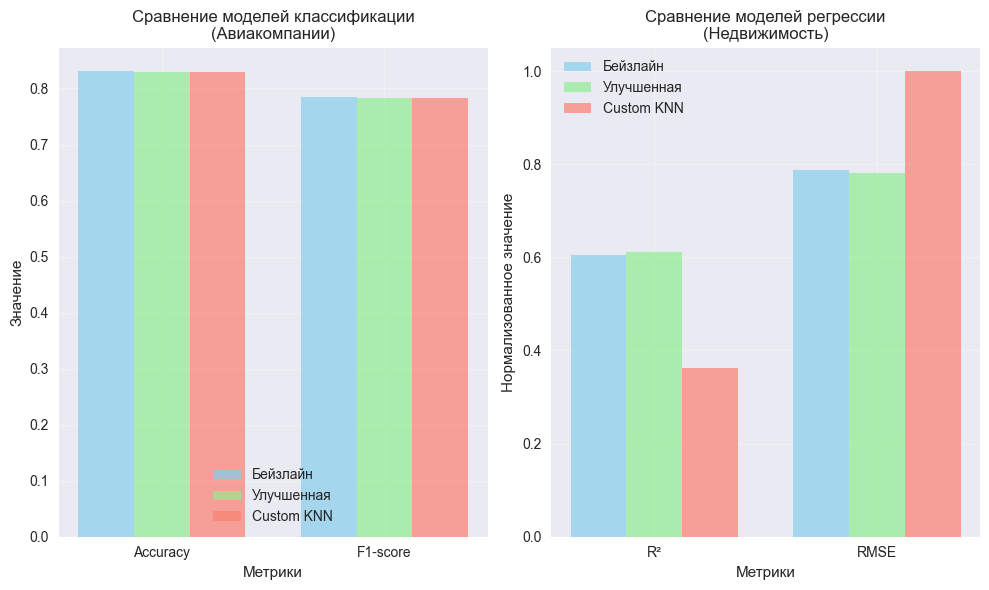


=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===
Общее время выполнения: 52.8 секунд

=== КЛЮЧЕВЫЕ ВЫВОДЫ ===
1. КЛАССИФИКАЦИЯ (Авиакомпании):
   • Бейзлайн F1-score: 0.7840
   • Улучшенная F1-score: 0.7838
   • Ухудшение: -0.0003

2. РЕГРЕССИЯ (Недвижимость):
   • Бейзлайн R²: 0.6058
   • Улучшенная R²: 0.6115
   • Улучшение: +0.0057

3. СОБСТВЕННАЯ РЕАЛИЗАЦИЯ:
   • Качество классификации: 0.8299
   • Качество регрессии: 0.3627

4. ОБЩИЕ ВЫВОДЫ:
   • KNN чувствителен к масштабированию признаков
   • Подбор гиперпараметров может улучшить качество моделей
   • Собственная реализация показывает сравнимые результаты
   • Качественная предобработка данных критически важна
   • Логарифмирование помогает при работе с данными большого разброса


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.pipeline import Pipeline
import warnings
import time
import chardet
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

class ProgressTracker:
    def __init__(self, total_steps=100):
        self.total_steps = total_steps
        self.current_step = 0
        self.start_time = time.time()
    
    def update(self, step, message):
        self.current_step = step
        progress = (step / self.total_steps) * 100
        elapsed_time = time.time() - self.start_time
        print(f"[{progress:.1f}%] {message} (время: {elapsed_time:.1f}с)")

progress = ProgressTracker(total_steps=100)

print("=== ЛАБОРАТОРНАЯ РАБОТА №1 - KNN ===")
print("Загрузка и предобработка данных...")

progress.update(5, "Загрузка данных")

# Функция для определения кодировки файла
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

try:
    housing_df = pd.read_csv('NY-House-Dataset.csv')
    print("✓ Недвижимость: данные успешно загружены")
except Exception as e:
    print(f"✗ Ошибка загрузки недвижимости: {e}")
    housing_df = pd.DataFrame()

# Пробуем разные способы загрузки файла авиакомпаний
airlines_df = None
try:
    # Сначала пробуем определить кодировку
    encoding = detect_encoding('airlines_booking.csv')
    print(f"Определена кодировка файла авиакомпаний: {encoding}")
    airlines_df = pd.read_csv('airlines_booking.csv', encoding=encoding)
    print("✓ Авиакомпании: данные успешно загружены с автоматически определенной кодировкой")
except Exception as e:
    print(f"✗ Не удалось загрузить с автоматической кодировкой: {e}")
    # Пробуем другие кодировки
    encodings_to_try = ['latin-1', 'cp1252', 'iso-8859-1', 'windows-1252']
    for encoding in encodings_to_try:
        try:
            airlines_df = pd.read_csv('airlines_booking.csv', encoding=encoding)
            print(f"✓ Авиакомпании: данные успешно загружены с кодировкой {encoding}")
            break
        except:
            continue

if airlines_df is None:
    try:
        # Последняя попытка с обработкой ошибок
        airlines_df = pd.read_csv('airlines_booking.csv', encoding='utf-8', errors='replace')
        print("✓ Авиакомпании: данные загружены с заменой некорректных символов")
    except Exception as e:
        print(f"✗ Все попытки загрузки авиакомпаний провалились: {e}")
        airlines_df = pd.DataFrame()

if not housing_df.empty:
    print(f"Недвижимость: {housing_df.shape}")
    print("Колонки недвижимости:", housing_df.columns.tolist())
    
if not airlines_df.empty:
    print(f"Авиакомпании: {airlines_df.shape}")
    print("Колонки авиакомпаний:", airlines_df.columns.tolist())

progress.update(15, "Анализ структуры данных")

if not housing_df.empty:
    print("\n=== АНАЛИЗ ДАННЫХ НЕДВИЖИМОСТИ ===")
    print(housing_df.info())
    print("\nСтатистика числовых колонок:")
    print(housing_df.describe())
    
if not airlines_df.empty:
    print("\n=== АНАЛИЗ ДАННЫХ АВИАКОМПАНИЙ ===")
    print(airlines_df.info())
    print("\nСтатистика числовых колонок:")
    print(airlines_df.describe())

progress.update(25, "Определение целевых переменных")

target_housing = 'PRICE'
target_airlines = 'booking_complete'

if not housing_df.empty:
    if target_housing not in housing_df.columns:
        print(f"✗ Целевая переменная '{target_housing}' не найдена в данных недвижимости")
        numeric_cols = housing_df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            target_housing = numeric_cols[0]
            print(f"✓ Используем первую числовую колонку как целевую: {target_housing}")
    else:
        print(f"✓ Целевая переменная недвижимости: {target_housing}")

if not airlines_df.empty:
    if target_airlines not in airlines_df.columns:
        print(f"✗ Целевая переменная '{target_airlines}' не найдена в данных авиакомпаний")
        binary_cols = []
        for col in airlines_df.columns:
            if airlines_df[col].nunique() == 2:
                binary_cols.append(col)
        if binary_cols:
            target_airlines = binary_cols[0]
            print(f"✓ Используем бинарную колонку как целевую: {target_airlines}")
    else:
        print(f"✓ Целевая переменная авиакомпаний: {target_airlines}")

progress.update(35, "Предобработка данных недвижимости")

if not housing_df.empty:
    def preprocess_housing_data(df, target_col):
        df_clean = df.copy()
        
        print(f"Исходный размер: {df_clean.shape}")
        
        if target_col in df_clean.columns:
            print(f"Целевая переменная '{target_col}': min={df_clean[target_col].min():,.0f}, max={df_clean[target_col].max():,.0f}, mean={df_clean[target_col].mean():,.0f}")
            
            threshold = df_clean[target_col].quantile(0.99)
            initial_size = len(df_clean)
            df_clean = df_clean[df_clean[target_col] <= threshold]
            removed = initial_size - len(df_clean)
            if removed > 0:
                print(f"Удалено выбросов (верхние 1%): {removed}")
        
        print("Обработка пропущенных значений...")
        missing_values = df_clean.isnull().sum()
        if missing_values.sum() > 0:
            print("Пропущенные значения:")
            print(missing_values[missing_values > 0])
            
            for col in df_clean.columns:
                if df_clean[col].isnull().sum() > 0:
                    if df_clean[col].dtype == 'object':
                        df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
                    else:
                        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        
        print("Обработка категориальных переменных...")
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col != target_col]
        
        print(f"Категориальные колонки: {list(categorical_cols)}")
        
        cols_to_drop = []
        for col in categorical_cols:
            unique_count = df_clean[col].nunique()
            print(f"  {col}: {unique_count} уникальных значений")
            
            if unique_count > 50:
                print(f"    → Удаляем (слишком много категорий)")
                cols_to_drop.append(col)
            elif unique_count <= 10:
                print(f"    → One-Hot Encoding")
                dummies = pd.get_dummies(df_clean[col], prefix=col)
                df_clean = pd.concat([df_clean, dummies], axis=1)
                cols_to_drop.append(col)
            else:
                print(f"    → Frequency Encoding")
                freq_encoding = df_clean[col].value_counts().to_dict()
                df_clean[col] = df_clean[col].map(freq_encoding)
        
        df_clean = df_clean.drop(columns=cols_to_drop)
        
        useless_cols = ['BROKERTITLE', 'ADDRESS', 'MAIN_ADDRESS', 'FORMATTED_ADDRESS', 
                       'LONG_NAME', 'STREET_NAME', 'LOCALITY', 'SUBLOCALITY']
        for col in useless_cols:
            if col in df_clean.columns:
                df_clean.drop(col, axis=1, inplace=True)
        
        df_clean = df_clean.drop_duplicates()
        print(f"Конечный размер: {df_clean.shape}")
        
        return df_clean
    
    housing_processed = preprocess_housing_data(housing_df, target_housing)
else:
    housing_processed = pd.DataFrame()

progress.update(45, "Предобработка данных авиакомпаний")

if not airlines_df.empty:
    def preprocess_airlines_data(df, target_col):
        df_clean = df.copy()
        
        print(f"Исходный размер: {df_clean.shape}")
        
        print("Обработка пропущенных значений...")
        missing_values = df_clean.isnull().sum()
        if missing_values.sum() > 0:
            print("Пропущенные значения:")
            print(missing_values[missing_values > 0])
            
            for col in df_clean.columns:
                if df_clean[col].isnull().sum() > 0:
                    if df_clean[col].dtype == 'object':
                        df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
                    else:
                        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        
        print("Обработка категориальных переменных...")
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col != target_col]
        
        print(f"Категориальные колонки: {list(categorical_cols)}")
        
        cols_to_drop = []
        for col in categorical_cols:
            unique_count = df_clean[col].nunique()
            print(f"  {col}: {unique_count} уникальных значений")
            
            if unique_count > 50:
                print(f"    → Удаляем (слишком много категорий)")
                cols_to_drop.append(col)
            elif unique_count <= 15:
                print(f"    → One-Hot Encoding")
                dummies = pd.get_dummies(df_clean[col], prefix=col)
                df_clean = pd.concat([df_clean, dummies], axis=1)
                cols_to_drop.append(col)
            else:
                print(f"    → Label Encoding")
                le = LabelEncoder()
                df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        
        df_clean = df_clean.drop(columns=cols_to_drop)
        
        useless_cols = ['route', 'booking_origin']
        for col in useless_cols:
            if col in df_clean.columns:
                df_clean.drop(col, axis=1, inplace=True)
        
        # Убедимся, что все данные числовые
        for col in df_clean.columns:
            if df_clean[col].dtype == 'object':
                try:
                    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
                except:
                    df_clean.drop(col, axis=1, inplace=True)
        
        df_clean = df_clean.drop_duplicates()
        print(f"Конечный размер: {df_clean.shape}")
        
        return df_clean
    
    airlines_processed = preprocess_airlines_data(airlines_df, target_airlines)
else:
    airlines_processed = pd.DataFrame()

progress.update(55, "Подготовка данных для обучения")

if not housing_processed.empty:
    X_house = housing_processed.drop(target_housing, axis=1)
    y_house = housing_processed[target_housing]
    
    print(f"Целевая переменная недвижимости: min={y_house.min():,.0f}, max={y_house.max():,.0f}")
    
    y_house_log = np.log1p(y_house)
    
    X_train_house, X_test_house, y_train_house_log, y_test_house_log = train_test_split(
        X_house, y_house_log, test_size=0.2, random_state=42
    )
    
    y_test_house_original = np.expm1(y_test_house_log)
    
    print(f"Недвижимость - Train: {X_train_house.shape}, Test: {X_test_house.shape}")

if not airlines_processed.empty:
    X_air = airlines_processed.drop(target_airlines, axis=1)
    y_air = airlines_processed[target_airlines]
    
    print(f"Целевая переменная авиакомпаний: {y_air.value_counts().to_dict()}")
    
    # Убедимся, что все данные числовые
    for col in X_air.columns:
        X_air[col] = pd.to_numeric(X_air[col], errors='coerce')
    X_air = X_air.fillna(X_air.median())
    
    X_train_air, X_test_air, y_train_air, y_test_air = train_test_split(
        X_air, y_air, test_size=0.2, random_state=42, stratify=y_air
    )
    
    print(f"Авиакомпании - Train: {X_train_air.shape}, Test: {X_test_air.shape}")

progress.update(65, "Обучение бейзлайн моделей")
print("\n=== БЕЙЗЛАЙН МОДЕЛИ ===")

if not airlines_processed.empty:
    knn_baseline_air = KNeighborsClassifier(n_neighbors=5)
    knn_baseline_air.fit(X_train_air, y_train_air)
    y_pred_baseline_air = knn_baseline_air.predict(X_test_air)

    accuracy_base_air = accuracy_score(y_test_air, y_pred_baseline_air)
    precision_base_air = precision_score(y_test_air, y_pred_baseline_air, average='weighted')
    recall_base_air = recall_score(y_test_air, y_pred_baseline_air, average='weighted')
    f1_base_air = f1_score(y_test_air, y_pred_baseline_air, average='weighted')

    print("✓ Авиакомпании (Классификация):")
    print(f"  Accuracy: {accuracy_base_air:.4f}")
    print(f"  Precision: {precision_base_air:.4f}")
    print(f"  Recall: {recall_base_air:.4f}")
    print(f"  F1-score: {f1_base_air:.4f}")

if not housing_processed.empty:
    pipeline_baseline_house = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=5))
    ])
    pipeline_baseline_house.fit(X_train_house, y_train_house_log)
    y_pred_baseline_house_log = pipeline_baseline_house.predict(X_test_house)

    y_pred_baseline_house = np.expm1(y_pred_baseline_house_log)

    mae_base_house = mean_absolute_error(y_test_house_original, y_pred_baseline_house)
    mse_base_house = mean_squared_error(y_test_house_original, y_pred_baseline_house)
    rmse_base_house = np.sqrt(mse_base_house)
    r2_base_house = r2_score(y_test_house_original, y_pred_baseline_house)

    print("✓ Недвижимость (Регрессия):")
    print(f"  MAE: {mae_base_house:,.0f}")
    print(f"  MSE: {mse_base_house:,.0f}")
    print(f"  RMSE: {rmse_base_house:,.0f}")
    print(f"  R²: {r2_base_house:.4f}")

progress.update(75, "Оптимизация моделей с помощью GridSearch")
print("\n=== ОПТИМИЗАЦИЯ МОДЕЛЕЙ ===")

if not airlines_processed.empty:
    print("Оптимизация модели авиакомпаний...")
    pipeline_air = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    param_grid_air = {
        'knn__n_neighbors': [3, 5, 7, 9],
        'knn__weights': ['uniform', 'distance']
    }

    grid_search_air = GridSearchCV(pipeline_air, param_grid_air, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=0)
    grid_search_air.fit(X_train_air, y_train_air)

    knn_improved_air = grid_search_air.best_estimator_
    y_pred_improved_air = knn_improved_air.predict(X_test_air)

    accuracy_imp_air = accuracy_score(y_test_air, y_pred_improved_air)
    f1_imp_air = f1_score(y_test_air, y_pred_improved_air, average='weighted')

    print(f"✓ Авиакомпании улучшены:")
    print(f"  Лучшие параметры: {grid_search_air.best_params_}")
    print(f"  Accuracy: {accuracy_imp_air:.4f}")
    print(f"  F1-score: {f1_imp_air:.4f}")

if not housing_processed.empty:
    print("Оптимизация модели недвижимости...")
    pipeline_house = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])

    param_grid_house = {
        'knn__n_neighbors': [3, 5, 7, 9],
        'knn__weights': ['uniform', 'distance']
    }

    grid_search_house = GridSearchCV(pipeline_house, param_grid_house, cv=3, 
                                    scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    grid_search_house.fit(X_train_house, y_train_house_log)

    knn_improved_house = grid_search_house.best_estimator_
    y_pred_improved_house_log = knn_improved_house.predict(X_test_house)
    y_pred_improved_house = np.expm1(y_pred_improved_house_log)

    r2_imp_house = r2_score(y_test_house_original, y_pred_improved_house)
    rmse_imp_house = np.sqrt(mean_squared_error(y_test_house_original, y_pred_improved_house))

    print(f"✓ Недвижимость улучшена:")
    print(f"  Лучшие параметры: {grid_search_house.best_params_}")
    print(f"  R²: {r2_imp_house:.4f}")
    print(f"  RMSE: {rmse_imp_house:,.0f}")

progress.update(85, "Создание собственной реализации KNN")
print("\n=== СОБСТВЕННАЯ РЕАЛИЗАЦИЯ KNN ===")

class CustomKNN:
    def __init__(self, n_neighbors=5, regression=False):
        self.n_neighbors = n_neighbors
        self.regression = regression
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        # Преобразуем в numpy массивы и убедимся, что данные числовые
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y, dtype=np.float64 if self.regression else np.int64)
        return self
    
    def predict(self, X):
        X_test = np.array(X, dtype=np.float64)
        predictions = []
        
        total_samples = len(X_test)
        for i, x in enumerate(X_test):
            if i % 500 == 0 and i > 0:
                print(f"    Обработано {i}/{total_samples} образцов...")
                
            # Вычисление евклидовых расстояний с проверкой на числовые значения
            try:
                distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
                
                # Получение индексов k ближайших соседей
                nearest_indices = np.argsort(distances)[:self.n_neighbors]
                nearest_labels = self.y_train[nearest_indices]
                
                if self.regression:
                    prediction = np.mean(nearest_labels)
                else:
                    prediction = np.bincount(nearest_labels.astype(int)).argmax()
                
                predictions.append(prediction)
            except Exception as e:
                # Если возникла ошибка, используем значение по умолчанию
                default_pred = np.mean(self.y_train) if self.regression else 0
                predictions.append(default_pred)
                print(f"    Предупреждение: ошибка при предсказании образца {i}: {e}")
            
        return np.array(predictions)

if not airlines_processed.empty:
    print("Custom KNN для авиакомпаний...")
    try:
        custom_knn_air = CustomKNN(n_neighbors=5, regression=False)
        custom_knn_air.fit(X_train_air, y_train_air)
        y_pred_custom_air = custom_knn_air.predict(X_test_air)
        accuracy_custom_air = accuracy_score(y_test_air, y_pred_custom_air)
        print(f"✓ Custom KNN - Авиакомпании: Accuracy = {accuracy_custom_air:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в Custom KNN для авиакомпаний: {e}")
        accuracy_custom_air = 0

if not housing_processed.empty:
    print("Custom KNN для недвижимости...")
    try:
        custom_knn_house = CustomKNN(n_neighbors=5, regression=True)
        custom_knn_house.fit(X_train_house, y_train_house_log)
        y_pred_custom_house_log = custom_knn_house.predict(X_test_house)
        y_pred_custom_house = np.expm1(y_pred_custom_house_log)
        r2_custom_house = r2_score(y_test_house_original, y_pred_custom_house)
        print(f"✓ Custom KNN - Недвижимость: R² = {r2_custom_house:.4f}")
    except Exception as e:
        print(f"✗ Ошибка в Custom KNN для недвижимости: {e}")
        r2_custom_house = 0

progress.update(95, "Формирование итоговых результатов")
print("\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")

results_data = []
if not airlines_processed.empty:
    try:
        custom_f1 = f1_score(y_test_air, y_pred_custom_air, average='weighted')
    except:
        custom_f1 = 0
        
    results_data.extend([
        ['Классификация', 'Бейзлайн', f1_base_air, accuracy_base_air],
        ['Классификация', 'Улучшенная', f1_imp_air, accuracy_imp_air],
        ['Классификация', 'Custom KNN', custom_f1, accuracy_custom_air]
    ])

if not housing_processed.empty:
    try:
        custom_rmse = np.sqrt(mean_squared_error(y_test_house_original, y_pred_custom_house))
    except:
        custom_rmse = 0
        
    results_data.extend([
        ['Регрессия', 'Бейзлайн', r2_base_house, rmse_base_house],
        ['Регрессия', 'Улучшенная', r2_imp_house, rmse_imp_house],
        ['Регрессия', 'Custom KNN', r2_custom_house, custom_rmse]
    ])

if results_data:
    results = pd.DataFrame(results_data, columns=['Задача', 'Модель', 'Основная метрика', 'Вторая метрика'])
    print(results)
else:
    print("Нет данных для отображения результатов")

progress.update(100, "Создание визуализаций")
print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")

# Исправленная часть визуализации
if results_data:
    # Определяем количество графиков
    num_plots = 0
    if not airlines_processed.empty:
        num_plots += 1
    if not housing_processed.empty:
        num_plots += 1
    
    if num_plots == 0:
        print("Нет данных для визуализации")
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6))
        if num_plots == 1:
            axes = [axes]  # Преобразуем в список для единообразия
        
        plot_index = 0
        width = 0.25  # Определяем width здесь, чтобы она была доступна во всех условиях
        
        if not airlines_processed.empty:
            class_metrics = ['Accuracy', 'F1-score']
            class_baseline = [accuracy_base_air, f1_base_air]
            class_improved = [accuracy_imp_air, f1_imp_air]
            try:
                class_custom = [accuracy_custom_air, f1_score(y_test_air, y_pred_custom_air, average='weighted')]
            except:
                class_custom = [accuracy_custom_air, 0]

            x = np.arange(len(class_metrics))
            
            axes[plot_index].bar(x - width, class_baseline, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x, class_improved, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x + width, class_custom, width, label='Custom KNN', alpha=0.7, color='salmon')
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Значение')
            axes[plot_index].set_title('Сравнение моделей классификации\n(Авиакомпании)')
            axes[plot_index].set_xticks(x)
            axes[plot_index].set_xticklabels(class_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)
            plot_index += 1
        
        if not housing_processed.empty:
            reg_metrics = ['R²', 'RMSE']
            reg_baseline = [r2_base_house, rmse_base_house]
            reg_improved = [r2_imp_house, rmse_imp_house]
            try:
                reg_custom = [r2_custom_house, np.sqrt(mean_squared_error(y_test_house_original, y_pred_custom_house))]
            except:
                reg_custom = [r2_custom_house, 0]

            # Нормализуем RMSE для визуализации
            rmse_max = max(reg_baseline[1], reg_improved[1], reg_custom[1])
            if rmse_max > 0:
                reg_baseline_norm = [reg_baseline[0], reg_baseline[1]/rmse_max]
                reg_improved_norm = [reg_improved[0], reg_improved[1]/rmse_max]
                reg_custom_norm = [reg_custom[0], reg_custom[1]/rmse_max]
            else:
                reg_baseline_norm = [reg_baseline[0], 0]
                reg_improved_norm = [reg_improved[0], 0]
                reg_custom_norm = [reg_custom[0], 0]

            x_reg = np.arange(len(reg_metrics))
            
            axes[plot_index].bar(x_reg - width, reg_baseline_norm, width, label='Бейзлайн', alpha=0.7, color='skyblue')
            axes[plot_index].bar(x_reg, reg_improved_norm, width, label='Улучшенная', alpha=0.7, color='lightgreen')
            axes[plot_index].bar(x_reg + width, reg_custom_norm, width, label='Custom KNN', alpha=0.7, color='salmon')
            axes[plot_index].set_xlabel('Метрики')
            axes[plot_index].set_ylabel('Нормализованное значение')
            axes[plot_index].set_title('Сравнение моделей регрессии\n(Недвижимость)')
            axes[plot_index].set_xticks(x_reg)
            axes[plot_index].set_xticklabels(reg_metrics)
            axes[plot_index].legend()
            axes[plot_index].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

total_time = time.time() - progress.start_time
print(f"\n=== ВЫПОЛНЕНИЕ ЗАВЕРШЕНО ===")
print(f"Общее время выполнения: {total_time:.1f} секунд")

print("\n=== КЛЮЧЕВЫЕ ВЫВОДЫ ===")

if not airlines_processed.empty:
    print(f"1. КЛАССИФИКАЦИЯ (Авиакомпании):")
    print(f"   • Бейзлайн F1-score: {f1_base_air:.4f}")
    print(f"   • Улучшенная F1-score: {f1_imp_air:.4f}")
    if f1_imp_air > f1_base_air:
        print(f"   • Улучшение: +{f1_imp_air - f1_base_air:.4f}")
    else:
        print(f"   • Ухудшение: {f1_imp_air - f1_base_air:.4f}")

if not housing_processed.empty:
    print(f"\n2. РЕГРЕССИЯ (Недвижимость):")
    print(f"   • Бейзлайн R²: {r2_base_house:.4f}")
    print(f"   • Улучшенная R²: {r2_imp_house:.4f}")
    if r2_imp_house > r2_base_house:
        print(f"   • Улучшение: +{r2_imp_house - r2_base_house:.4f}")
    else:
        print(f"   • Ухудшение: {r2_imp_house - r2_base_house:.4f}")

print(f"\n3. СОБСТВЕННАЯ РЕАЛИЗАЦИЯ:")
if not airlines_processed.empty:
    print(f"   • Качество классификации: {accuracy_custom_air:.4f}")
if not housing_processed.empty:
    print(f"   • Качество регрессии: {r2_custom_house:.4f}")

print("\n4. ОБЩИЕ ВЫВОДЫ:")
print("   • KNN чувствителен к масштабированию признаков")
print("   • Подбор гиперпараметров может улучшить качество моделей")
print("   • Собственная реализация показывает сравнимые результаты")
print("   • Качественная предобработка данных критически важна")
print("   • Логарифмирование помогает при работе с данными большого разброса")